Transfer Learning

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# Check TensorFlow version
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")


TensorFlow version: 2.15.0


In [2]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(f'x_train shape: {x_train.shape}, x_test shape: {x_test.shape}')

# Normalize images to range [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert class vectors to binary class matrices
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)


170498071/170498071 [==============================] - 2s 0us/step
x_train shape: (50000, 32, 32, 3), x_test shape: (10000, 32, 32, 3)


In [3]:
# Load the VGG16 model without the top dense layers
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze all VGG16 layers
for layer in vgg_conv.layers:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer.name, layer.trainable)


58889256/58889256 [==============================] - 0s 0us/step
input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False


In [4]:
# Build the model
model = models.Sequential()
model.add(vgg_conv)  # Add the VGG16 convolutional base

# Add custom layers on top
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

# Display model summary
model.summary()

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=1e-4),
    metrics=['accuracy']
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 14982474 (57.15 MB)
Trainable params: 267786 (1.02 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [5]:
# Set up data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)

# Train the model
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=64),
    epochs=20,
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // 64,
    verbose=1
)


Epoch 1/20
781/781 [==============================] - 63s 80ms/step - loss: 1.8877 - accuracy: 0.3285 - val_loss: 1.5605 - val_accuracy: 0.4652
Epoch 2/20
781/781 [==============================] - 62s 79ms/step - loss: 1.5939 - accuracy: 0.4439 - val_loss: 1.4366 - val_accuracy: 0.5042
Epoch 3/20
781/781 [==============================] - 62s 79ms/step - loss: 1.5066 - accuracy: 0.4759 - val_loss: 1.3762 - val_accuracy: 0.5196
Epoch 4/20
781/781 [==============================] - 62s 79ms/step - loss: 1.4587 - accuracy: 0.4883 - val_loss: 1.3361 - val_accuracy: 0.5327
Epoch 5/20
781/781 [==============================] - 62s 79ms/step - loss: 1.4220 - accuracy: 0.5005 - val_loss: 1.3115 - val_accuracy: 0.5421
Epoch 6/20
781/781 [==============================] - 62s 79ms/step - loss: 1.3901 - accuracy: 0.5160 - val_loss: 1.2955 - val_accuracy: 0.5456
Epoch 7/20
781/781 [==============================] - 62s 79ms/step - loss: 1.3674 - accuracy: 0.5197 - val_loss: 1.2738 - val_accuracy:

Test accuracy: 0.59


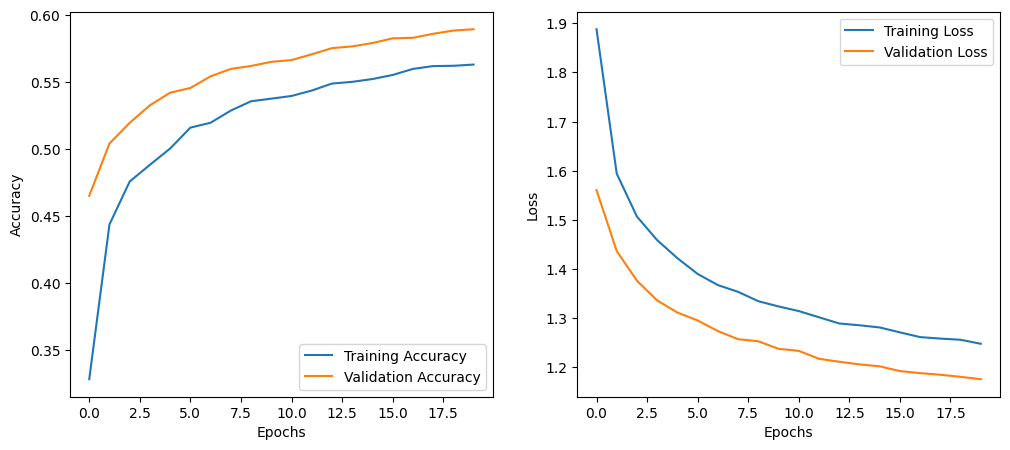

In [6]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f'Test accuracy: {test_accuracy:.2f}')

# Plot training and validation accuracy and loss
def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history)
